In [1]:
%load_ext autoreload
%autoreload 2


#### Import required Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

##### Ignoring Warnings

In [3]:
import warnings
warnings.filterwarnings('ignore')


Import modules

In [15]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from preprocessing import PreProcess
from overview import Overview
from plot import Plot

#### Import the Data

In [137]:
# df = pd.read_excel('../data/Week1_challenge_data_source.xlsx')
df_org = pd.read_csv('../data/cleaned_data_outliers.csv')

In [138]:
df = df_org.copy()

In [139]:
pl = Plot()
overview = Overview(df)

Data overview

In [140]:
df.head()

,bearer_id,start,start_ms,end,end_ms,dur._(ms),imsi,msisdn/number,imei,last_location_name,...,youtube_dl_(bytes),youtube_ul_(bytes),netflix_dl_(bytes),netflix_ul_(bytes),gaming_dl_(bytes),gaming_ul_(bytes),other_dl_(bytes),other_ul_(bytes),total_ul_(bytes),total_dl_(bytes)
0,1.311448e+19,2019-04-04 12:01:18,770.0,2019-04-25 14:35:31,662.0,0.996516,2.082014e+14,3.366496e+10,3.552121e+13,9164566995485190,...,0.970502,0.822514,0.921154,0.938287,0.912787,0.988555,0.872215,0.945762,0.771197,0.778526
1,1.311448e+19,2019-04-09 13:04:04,235.0,2019-04-25 08:15:48,606.0,0.944446,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,0.989326,0.988470,0.982026,0.981643,0.974370,0.788814,0.962224,0.991811,0.886427,0.933206
2,1.311448e+19,2019-04-09 17:42:11,1.0,2019-04-25 11:58:13,652.0,0.944006,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,0.987317,0.967048,0.978865,0.904660,0.897724,0.702334,0.942217,0.882317,0.687728,0.758117
3,1.311448e+19,2019-04-10 00:31:25,486.0,2019-04-25 07:36:35,171.0,0.938611,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,0.993545,0.969493,0.961585,0.775449,0.995798,0.966299,0.990469,0.977834,0.820953,0.986552
4,1.311448e+19,2019-04-12 20:10:23,565.0,2019-04-25 10:40:32,954.0,0.903820,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,0.967557,0.987831,0.976847,0.702620,0.963140,0.876788,0.965772,0.985008,0.785599,0.904707


#### User Engagement Analysis

##### Total data volume (in Bytes) during this session for each application


In [141]:
df["social_media"] = df["social_media_dl_(bytes)"] + df['social_media_ul_(bytes)']
df["google"] = df["google_dl_(bytes)"] + df["google_ul_(bytes)"]
df['email'] = df["email_dl_(bytes)"] + df["email_ul_(bytes)"]
df['youtube'] = df["youtube_dl_(bytes)"] + df["youtube_ul_(bytes)"]
df['netflix'] = df["netflix_dl_(bytes)"] + df["netflix_ul_(bytes)"]
df["gaming"] = df["gaming_dl_(bytes)"] + df["gaming_ul_(bytes)"]
df['other'] = df["other_dl_(bytes)"]+df["other_ul_(bytes)"]
df['total_data'] = df['total_dl_(bytes)'] + df['total_ul_(bytes)']

In [142]:
df.columns

Index(['bearer_id', 'start', 'start_ms', 'end', 'end_ms', 'dur._(ms)', 'imsi',
       'msisdn/number', 'imei', 'last_location_name', 'avg_rtt_dl_(ms)',
       'avg_rtt_ul_(ms)', 'avg_bearer_tp_dl_(kbps)', 'avg_bearer_tp_ul_(kbps)',
       'tcp_dl_retrans._vol_(bytes)', 'tcp_ul_retrans._vol_(bytes)',
       'dl_tp_<_50_kbps_(%)', '50_kbps_<_dl_tp_<_250_kbps_(%)',
       '250_kbps_<_dl_tp_<_1_mbps_(%)', 'dl_tp_>_1_mbps_(%)',
       'ul_tp_<_10_kbps_(%)', '10_kbps_<_ul_tp_<_50_kbps_(%)',
       '50_kbps_<_ul_tp_<_300_kbps_(%)', 'ul_tp_>_300_kbps_(%)',
       'http_dl_(bytes)', 'http_ul_(bytes)', 'activity_duration_dl_(ms)',
       'activity_duration_ul_(ms)', 'dur._(ms).1', 'handset_manufacturer',
       'handset_type', 'nb_of_sec_with_125000b_<_vol_dl',
       'nb_of_sec_with_1250b_<_vol_ul_<_6250b',
       'nb_of_sec_with_31250b_<_vol_dl_<_125000b',
       'nb_of_sec_with_37500b_<_vol_ul',
       'nb_of_sec_with_6250b_<_vol_dl_<_31250b',
       'nb_of_sec_with_6250b_<_vol_ul_<_37500b',


Aggregate the number of session durations, total session duration, & total data for each user

In [143]:
df = df.rename( columns={'bearer_id': 'sessions'})

In [144]:
user_engagement = df.groupby('msisdn/number').agg({'sessions': 'count', 'dur._(ms)': 'sum', 'total_data': 'sum'})

In [145]:
user_engagement.head()

,sessions,dur._(ms),total_data
msisdn/number,,,
3.360100e+10,1,0.502300,1.751134
3.360100e+10,1,0.581407,1.350465
3.360100e+10,1,0.528418,1.691663
3.360101e+10,1,0.349441,1.425098
3.360101e+10,2,0.343253,3.558224


#### 2.1 Users data analysis

Get the top 10 users with the highest total data volume, sessions, & session duration

Aggregate the above metrics per customer id (MSISDN) and report the top 10 customers per engagement metric 


In [146]:
user_engagement.shape

(106856, 3)

In [147]:
# user_engagement = user_engagement[user_engagement.index.str.contains("3.366371e+10") == False]
user_engagement.drop(33663706799.0, axis=0, inplace=True)

In [148]:
sessions = user_engagement.nlargest(10, "sessions")['sessions']
duration = user_engagement.nlargest(10, "dur._(ms)")['dur._(ms)']
total_data = user_engagement.nlargest(10, "total_data")['total_data']


In [149]:
sesssions_df = pd.DataFrame()
sesssions_df['User_ID'] = sessions.index
sesssions_df['Sessions'] = sessions.values
durations_df = pd.DataFrame()
durations_df['User_ID'] = duration.index
durations_df['duration'] = duration.values
total_data_df = pd.DataFrame()
total_data_df['User_ID'] = total_data.index
total_data_df['total_data'] = total_data.values

In [150]:
sesssions_df.head()

,User_ID,Sessions
0,3.362632e+10,18
1,3.361489e+10,17
2,3.362578e+10,17
3,3.365973e+10,16
4,3.367588e+10,15


In [151]:
durations_df.head()


,User_ID,duration
0,3.362578e+10,14.843524
1,3.362632e+10,12.989967
2,3.361489e+10,12.871815
3,3.376054e+10,11.266070
4,3.366716e+10,10.296854


In [134]:
total_data_df.head()

,User_ID,total_data
0,3.361489e+10,8.846226e+09
1,3.376054e+10,8.514774e+09
2,3.362578e+10,8.499621e+09
3,3.362632e+10,7.971167e+09
4,3.367588e+10,7.891111e+09


[Text(0, 0, '33614892860.0'),
 Text(1, 0, '33625779332.0'),
 Text(2, 0, '33626320676.0'),
 Text(3, 0, '33659725664.0'),
 Text(4, 0, '33667163239.0'),
 Text(5, 0, '33675877202.0'),
 Text(6, 0, '33698792269.0'),
 Text(7, 0, '33760413819.0'),
 Text(8, 0, '33760536639.0'),
 Text(9, 0, '33786323068.0')]

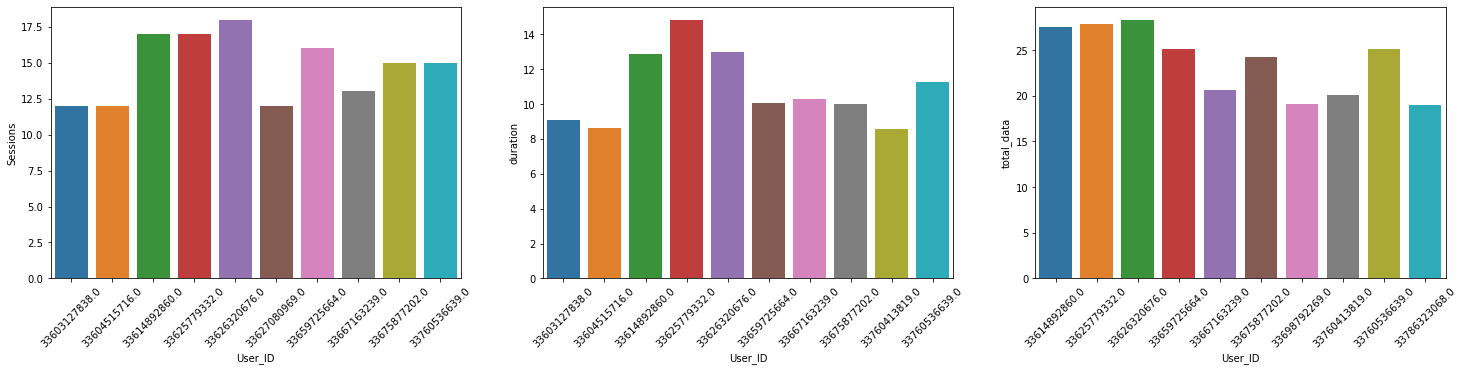

In [152]:
f, axes = plt.subplots(1, 3, figsize=(25, 5))
ax1 = sns.barplot(data=sesssions_df, x='User_ID', orient='v', y='Sessions', ax=axes[0])
ax2 = sns.barplot(data=durations_df, x='User_ID',orient='v', y='duration', ax=axes[1])
ax3 = sns.barplot(data=total_data_df, x='User_ID',orient='v', y='total_data', ax=axes[2])
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=45)
ax2.set_xticklabels(ax2.xaxis.get_majorticklabels(), rotation=45)
ax3.set_xticklabels(ax3.xaxis.get_majorticklabels(), rotation=45)


Normalize each engagement metric and run a k-means (k=3) to classify customers in three groups of engagement. 


In [181]:
from sklearn.preprocessing import Normalizer

def normalizer(df, columns):
    norm = Normalizer()
    # normalize the exponential data with boxcox
    normalized_data = norm.fit_transform(df)

    # plot both together to compare
    fig, ax=plt.subplots(1,2, figsize=(10, 6))
    sns.histplot(df, ax=ax[0])
    ax[0].set_title("Original Data")
    sns.histplot(normalized_data[0], ax=ax[1])
    ax[1].set_title("Normalized data")
    return pd.DataFrame(norm.fit_transform(df), columns=columns)

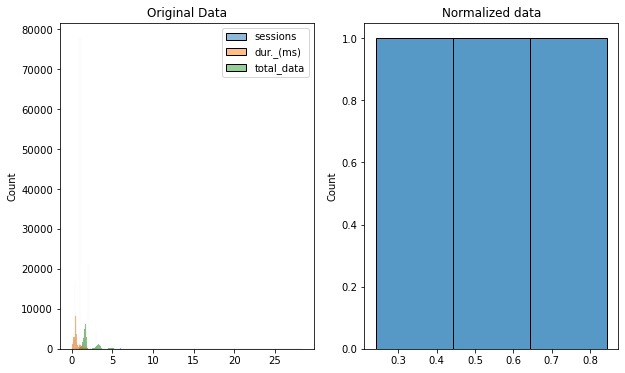

In [185]:
normalized_user_engagement = normalizer(user_engagement, ['sessions', 'dur._(ms)', 'total_data'] )

In [186]:
normalized_user_engagement.head()

,sessions,dur._(ms),total_data
0,0.481193,0.241704,0.842634
1,0.562385,0.326974,0.759481
2,0.491417,0.259674,0.831312
3,0.563167,0.196794,0.802568
4,0.488258,0.083798,0.868667


In [187]:
normalized_user_engagement.describe()

,sessions,dur._(ms),total_data
count,106855.000000,106855.000000,106855.000000
mean,0.516132,0.223813,0.822405
std,0.039218,0.067179,0.033396
min,0.428995,0.000000,0.458651
25%,0.488358,0.190006,0.807443
50%,0.508575,0.232999,0.828997
75%,0.535401,0.267627,0.845068
max,0.794010,0.511353,0.889744


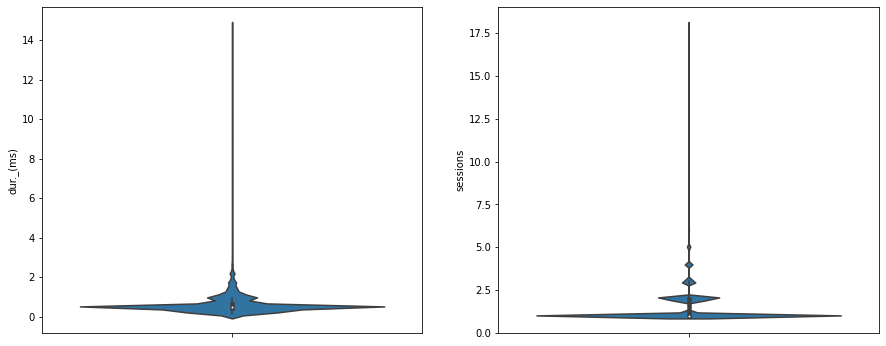

In [180]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.violinplot(y=user_engagement["dur._(ms)"])
# sns.boxplot(y=user_engagement["dur._(ms)"], color="red")
plt.subplot(1,2,2)
sns.violinplot(y=user_engagement["sessions"])
# sns.boxplot(y=user_engagement["total_data"])
plt.show()


Most of the duration,and the number of sessions lies between 1 - 2 